In [4]:
## import packages and functions
import ase
import numpy as np
from ase.io import read, write #input/output
from ase.visualize import view #visualisation
from ase.calculators.lammpslib import LAMMPSlib #lammps calculator


# LAMMPS calculator
atom_types = {'O' : 2, 'H' : 1}
cmd_nn = [      "#!/bin/bash",
                "variable runnerDir       string \"/lustre/home/tccourse/ZEN/TEST/train_008\"",
                "variable runnerCutoff    equal  8.466835984",
                "pair_style hdnnp ${runnerCutoff} dir ${runnerDir} showew no showewsum 1 resetew yes maxew 200000 cflength 1.889726 cfenergy 0.036749",
                "pair_coeff * * H O",
        ]
LAMMPScalc = LAMMPSlib(atom_types=atom_types, lmpcmds=cmd_nn, tmp_dir="./", log_file='log.lammps', keep_alive=True)
LAMMPScalc

In [6]:
## LOAD A GEOMETRY AND COMPUTE ITS ENERGY 

atoms=read('POSCAR') #load initial geometry as an atom environment
atoms.calc=LAMMPScalc # attach a calculator
view(atoms)

<Popen: returncode: None args: ['/lustre/home/tccourse/.conda/envs/Py310/bin...>

In [7]:
energy=atoms.get_potential_energy() #compute the potential energy (total electronic energy) of the loaded geometry
print('energy: ',energy)

forces=atoms.get_forces() # compute the forces on each atom
print('forces: \n', forces)

energy:  -5635.113732815746
forces: 
 [[-8.61416416e-04 -1.70265724e-03 -6.73347629e-01]
 [ 6.67150900e-03 -2.89426891e-03 -6.72835680e-01]
 [-5.67885723e-03  4.45083970e-03 -6.72650143e-01]
 [-5.64982928e-03  4.20562679e-04 -6.56982506e-01]
 [-7.18915773e-03 -1.22745415e-02 -7.26777022e-01]
 [ 3.10359447e-03 -4.81738876e-03 -6.56845182e-01]
 [ 6.24258518e-01  6.30486205e-03  2.05072342e-01]
 [-2.95836272e-01 -5.12887453e-01  2.32648460e-01]
 [-3.06745851e-01  5.44030139e-01  2.05178558e-01]
 [-6.17499568e-01  6.28065883e-04  1.96555658e-01]
 [ 2.95195608e-01  5.11765145e-01  1.93068104e-01]
 [ 3.09347780e-01 -5.34577777e-01  1.96708730e-01]
 [ 2.99383345e-01  5.29531424e-01 -2.13856881e-01]
 [ 2.96883972e-01 -5.28622840e-01 -2.13465755e-01]
 [ 1.98912944e-01 -1.44261849e-01  6.43718564e-02]
 [-6.06135099e-01 -7.09428567e-03 -2.13378376e-01]
 [ 3.08791677e-01  5.24041544e-01 -2.13587213e-01]
 [-3.14016111e-01  5.27593151e-01 -2.20713574e-01]
 [-3.01787104e-01 -5.34378182e-01 -2.2080208

In [10]:
## PERFORM GEOMETRY OPTIMISATION (KEEPING THE CELL FIXED)

from ase.optimize import BFGS # import the optimiser
from ase.io.trajectory import Trajectory # i/o to save dynamics trajectory

geo=atoms.copy()
geo.calc=LAMMPScalc

#define path to store the trajectory file
path='relax-positions/'

#check if the directory 'relax-positions' exists - if not, create it
import os 
if not os.path.exists(str(path)): 
    os.makedirs(str(path)) 

# run optimisation
dyn = BFGS(geo) # create the optimiser object associated to the atoms  'geo' with calculator 'LAMMPScalc'

traj=Trajectory(path+'simulation.traj','w',geo) # define Trajectory object
dyn.attach(traj) # attach Trajectory to optimiser

dyn.run(fmax=0.03) # relax the atoms position until the forces are < 0.03 ev/Å

      Step     Time          Energy         fmax
BFGS:    0 09:58:33    -5635.113733        0.8537
BFGS:    1 09:58:33    -5635.245878        0.2029
BFGS:    2 09:58:33    -5635.251694        0.1768
BFGS:    3 09:58:34    -5635.255715        0.1339
BFGS:    4 09:58:34    -5635.257866        0.0672
BFGS:    5 09:58:34    -5635.258090        0.0498
BFGS:    6 09:58:34    -5635.258188        0.0404
BFGS:    7 09:58:34    -5635.258318        0.0226


True

In [12]:
# write final (optimised) geometry 
write(images=geo,filename=path+'final.pbd',format='proteindatabank')
from ase.build import sort
write(images=sort(geo),filename=path+'POSCAR',format='vasp')
atoms

Atoms(symbols='H24O12', pbc=True, cell=[[7.678093, 0.0, 0.0], [3.839046, 6.649423, 0.0], [0.0, 0.0, 7.234567]], calculator=LAMMPSlib(...))

In [13]:
## PERFORM FULL GEOMETRY OPTIMISATION (ATOMS + CELL)

from ase.optimize import QuasiNewton # import the optimiser
from ase.constraints import UnitCellFilter # import the CellFilter object: it's a wrapper that creates an Atoms object with a variable cell
from ase import units #for easier units conversions


#define path to store the trajectory file
path='relax-full/'

#check if the directory 'relax-full' exists - if not, create it
import os 
if not os.path.exists(str(path)): 
    os.makedirs(str(path)) 

for pressure in [0,1]:
    geo=atoms.copy()   # atoms object 
    geo.calc=LAMMPScalc    # attach calculator
    
    ucf = UnitCellFilter(geo,scalar_pressure=pressure*units.GPa) # define the atoms object with variable cell
    qn = QuasiNewton(ucf) # optimiser is defined for the UnitCellFilter not for the initial atoms object!!!
    
    traj = Trajectory(path+'simulation_'+str(pressure)+'GPa.traj', 'w', geo) # define the Trajectory object
    qn.attach(traj) # attach trajectory to optimiser
     
    qn.run(fmax=0.03)
    write(images=geo,filename=path+'/final_P'+str(pressure)+'GPa.pdb',format='proteindatabank')

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 10:00:28    -5635.113733*       0.8537
BFGSLineSearch:    1[  2] 10:00:28    -5635.246590*       0.1996
BFGSLineSearch:    2[  4] 10:00:28    -5635.254589*       0.4076
BFGSLineSearch:    3[  6] 10:00:29    -5635.257774*       0.0779
BFGSLineSearch:    4[  8] 10:00:29    -5635.257971*       0.0640
BFGSLineSearch:    5[  9] 10:00:29    -5635.258280*       0.0482
BFGSLineSearch:    6[ 11] 10:00:29    -5635.258332*       0.0263
                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 10:00:29    -5632.808369*       0.8537
BFGSLineSearch:    1[  2] 10:00:30    -5632.941912*       0.1987
BFGSLineSearch:    2[  4] 10:00:30    -5632.950446*       0.4219
BFGSLineSearch:    3[  6] 10:00:30    -5632.953972*       0.0725
BFGSLineSearch:    4[  8] 10:00:30    -5632.954464*      

In [ ]:
## PHONONS CALCULATION
from ase.phonons import Phonons
from ase.thermochemistry import CrystalThermo


import os, shutil
path = './phonon'
if (os.path.exists(path)):
    shutil.rmtree(path)


geo=read('relax-full/final_P0GPa.pdb') # start from relaxed geometry
geo.calc=LAMMPScalc
potentialenergy=geo.get_potential_energy()

ph = Phonons(geo, LAMMPScalc, supercell=(1, 1, 1), delta=0.02) # compute phonons with small displacement method - set supercell and ∆x (in Å)
ph.run()
ph.read(acoustic=True)
phonon_energies, phonon_DOS = ph.dos(kpts=(10, 10, 10), npts=1000,
                                     delta=5e-4)

# Calculate the Helmholtz free energy
thermo = CrystalThermo(phonon_energies=phonon_energies,
                       phonon_DOS=phonon_DOS,
                       potentialenergy=potentialenergy,
                       formula_units=1)

In [17]:
# use the phonons to compute the helmholtz free energy

free=[] # where we save the free energy
for temp in np.arange(10,300,10):
        F = thermo.get_helmholtz_energy(temperature=temp) # exact free energy at a fixed temperature
        free.append([temp,F])
free=np.array(free)

nmol=atoms.get_global_number_of_atoms()/3. #number of water molecules
free[:,1] /= nmol  #free energy per water molecule

Internal energy components at T = 10.00 K,
on a per-formula-unit basis:
E_pot             -5635.2583 eV
E_ZPE                 8.7080 eV
E_phonon              0.0002 eV
-------------------------------
U                 -5626.5500 eV

Entropy components at T = 10.00 K,
on a per-formula-unit basis:
                           S               T*S
-------------------------------------------------
S                  0.0000462 eV/K       0.0005 eV

Helmholtz free energy components at T = 10.00 K,
on a per-formula-unit basis:
    U     -5626.5500 eV
 -T*S        -0.0005 eV
-----------------------
    F     -5626.5505 eV
Internal energy components at T = 20.00 K,
on a per-formula-unit basis:
E_pot             -5635.2583 eV
E_ZPE                 8.7080 eV
E_phonon              0.0010 eV
-------------------------------
U                 -5626.5493 eV

Entropy components at T = 20.00 K,
on a per-formula-unit basis:
                           S               T*S
-------------------------------------

findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.


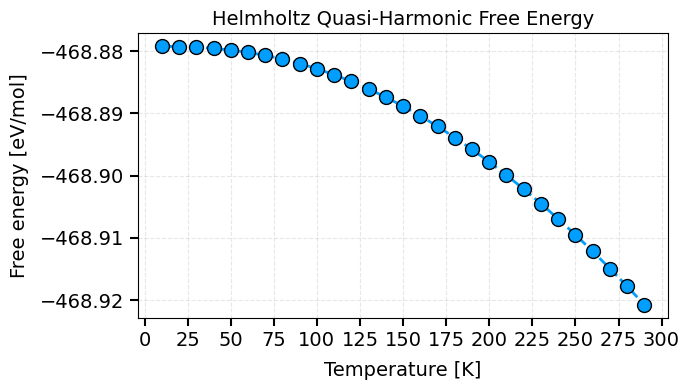

In [18]:
## PLOT 

import matplotlib.pyplot as plt
blue='#009fff'

fig, ax = plt.subplots(figsize=(7,4))

ax.plot(free[:,0],free[:,1],linestyle='--',linewidth=2.,marker='o',mec='black',color=blue,markersize=10)

ax.tick_params(direction='out', width=1.5,length=6)

plt.xticks(np.arange(0,325,25),fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel('Free energy [eV/mol]',fontname='arial',fontsize=14,labelpad=8)
plt.xlabel('Temperature [K]',fontname='arial',fontsize=14,labelpad=8)

plt.title('Helmholtz Quasi-Harmonic Free Energy',fontname='arial',fontsize=14)
plt.grid(ls='--',alpha=.3)
plt.tight_layout()
plt.show()

In [19]:
## liquid water NVT
from ase.md.langevin import Langevin

geo=read('h2o-128.pdb')
#geo=atoms.copy()
geo.calc=LAMMPScalc

#define path to store the trajectory file
path='MD-NVT/'

#check if the directory 'MD-NVT' exists - if not, create it
import os 
if not os.path.exists(str(path)): 
    os.makedirs(str(path)) 

dyn = Langevin(
    geo,
    timestep=1.0 * units.fs, # MD time step in femtoseconds (1.0 fs not accurate)
    temperature_K=300.0,  # temperature in K
    friction=0.01 / units.fs,
    trajectory=path+'simulation.traj',
    loginterval=10
)

dyn.run(1000) # run 1000 MD steps: 1000*0.5 fs = 0.05 ps

True

In [20]:
## compute Radial Distribution Function
from ase.geometry import analysis
traj=Trajectory('MD-NVT/simulation.traj','r')
rdf=[]

rmax=7
nbins=80 

for i in range(len(traj)):
    geo=traj[i].copy()
    del geo[geo.numbers == 1]
    data=analysis.get_rdf(atoms=geo,rmax=rmax,nbins=nbins)
    rdf.append(data[0])
### average rdf
av_rdf=0
for i in range(len(rdf)):
    av_rdf += rdf[i]/len(rdf)

findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.


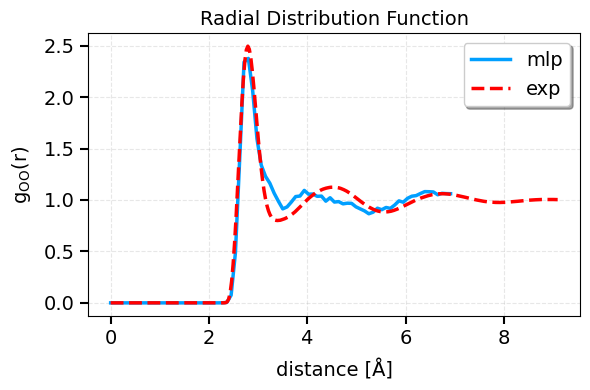

In [21]:
### plot rdf

exp=np.loadtxt('rdf-exp',usecols=(0,1))
fig, ax = plt.subplots(figsize=(6,4))

x=np.arange(0,rmax,rmax/nbins)
ax.plot(x,av_rdf,linestyle='-',lw=2.5,c=blue,label='mlp')
ax.plot(exp[:,0],exp[:,1],linestyle='--',lw=2.5,c='red',label='exp')


ax.tick_params(direction='out', width=1.5,length=6)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel('g$_\mathrm{OO}$(r)',fontname='arial',fontsize=14,labelpad=8)
plt.xlabel('distance [Å]',fontname='arial',fontsize=14,labelpad=8)
plt.title('Radial Distribution Function',fontname='arial',fontsize=14)
plt.grid(ls='--',alpha=.3)
plt.legend(fontsize=14,shadow=True)
plt.tight_layout()
plt.show()